In [1]:
import os
from tqdm import tqdm

path = '/share/jproject/fg538/r-006-gpu-4/data'
train_count = 0
val_count = 0

for folder in tqdm(os.listdir('{}/keras_data/train_dir/'.format(path))):
    train_count += len(os.listdir('{}/keras_data/train_dir/{}/'.format(path, folder)))
    val_count += len(os.listdir('{}/keras_data/val_dir/{}/'.format(path, folder)))
train_count, val_count

100%|██████████| 100/100 [00:10<00:00,  9.57it/s]


(999896, 81574)

In [6]:
import keras
from keras.models import load_model
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 299, 299
train_data_dir = "/share/jproject/fg538/r-006-gpu-4/data/keras_data/train_dir/"
validation_data_dir = "/share/jproject/fg538/r-006-gpu-4/data/keras_data/val_dir/"
batch_size = 32
epochs = 2
nb_classes = 100

train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                    target_size=(img_width, img_height), 
                                                    batch_size=batch_size)
val_generator = val_datagen.flow_from_directory(validation_data_dir, 
                                                target_size=(img_width, img_height), 
                                                batch_size=batch_size)

model = applications.inception_v3.InceptionV3(weights="imagenet", 
                                              include_top=False, 
                                              input_shape = (img_width, img_height, 3))
#model.summary()

#Adding custom Layer 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(nb_classes, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9),
                    metrics=["accuracy"])

# callbacks
# Save the model according to the conditions 
checkpoint = ModelCheckpoint("inception_v3_3.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)
#early = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=1, mode='auto')
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', 
                                          histogram_freq=1, 
                                          batch_size=batch_size, 
                                          write_graph=True,
                                          write_grads=True)

# Train the model 
history = model_final.fit_generator(train_generator, 
                                    steps_per_epoch=train_count//batch_size, 
                                    epochs=epochs, 
                                    verbose=1,
                                    #callbacks=[tensorboard],
                                    validation_data=val_generator,
                                    validation_steps=val_count//batch_size,
                                    class_weight='auto')

Found 999896 images belonging to 100 classes.
Found 81574 images belonging to 100 classes.
Epoch 1/2
31246/31246 [==============================] - 20977s 671ms/step - loss: 0.5349 - acc: 0.8764 - val_loss: 0.1780 - val_acc: 0.9657
Epoch 2/2
31246/31246 [==============================] - 7716s 247ms/step - loss: 0.1450 - acc: 0.9692 - val_loss: 0.1486 - val_acc: 0.9746


Batch Size: 32

Epoch 1/2

24741/24741 [==============================] - 7572s 306ms/step - loss: 0.6151 - acc: 0.8571 - val_loss: 0.1639 - val_acc: 0.9688


Epoch 2/2

24741/24741 [==============================] - 7494s 303ms/step - loss: 0.1615 - acc: 0.9666 - val_loss: 0.1144 - val_acc: 0.9794

Text(0.5,1,'Training and validation accuracy')

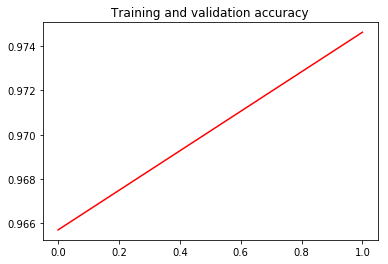

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

#plt.plot(epochs, acc, 'r.')
plt.plot(epochs, val_acc, 'r')
plt.title('Training and validation accuracy')

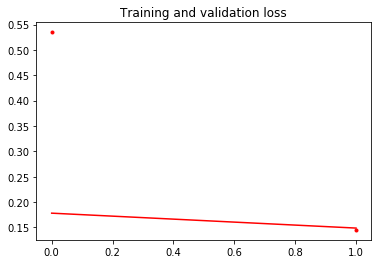

In [9]:
plt.figure()
plt.plot(epochs, loss, 'r.')
plt.plot(epochs, val_loss, 'r-')
plt.title('Training and validation loss')
plt.show()